In [1]:
# https://deeplearningcourses.com/c/deep-learning-advanced-nlp
# https://github.com/lazyprogrammer/machine_learning_examples/blob/master/nlp_class3/cnn_toxic.py
# https://github.com/jatana-research/Text-Classification/blob/master/CNN.ipynb
from __future__ import print_function, division
from builtins import range

import os
import sys
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.layers import Dense, Input, GlobalMaxPooling1D
from keras.layers import Conv1D, MaxPooling1D, Embedding
from keras.models import Model
# from sklearn.metrics import roc_auc_score


# For Google Colaboratory
from google.colab import drive
drive.mount('/content/gdrive')


# Download the word vectors:
# http://nlp.stanford.edu/data/glove.6B.zip

# some configuration
MAX_SEQUENCE_LENGTH = 20106
MAX_VOCAB_SIZE = 20000
EMBEDDING_DIM = 100
VALIDATION_SPLIT = 0.2
BATCH_SIZE = 128
EPOCHS = 10



# load in pre-trained word vectors
# print('Loading word vectors...')
word2vec = {}
with open(os.path.join('/content/gdrive/My Drive/projects/spark/neural_net/glove.6B/glove.6B.%sd.txt' % EMBEDDING_DIM)) as f:
  # is just a space-separated text file in the format:
  # word vec[0] vec[1] vec[2] ...
  for line in f:
    values = line.split()
    word = values[0]
    vec = np.asarray(values[1:], dtype='float32')
    word2vec[word] = vec
# print('Found %s word vectors.' % len(word2vec))



# prepare text samples and their labels
# print('Loading in comments...')


train = pd.read_csv("/content/gdrive/My Drive/projects/spark/neural_net/preprocessing/preprocessed_data.csv")
sentences = train["case_text"].values
possible_labels = ["misconduct"]
targets = train[possible_labels].values



# convert the sentences (strings) into integers
tokenizer = Tokenizer(num_words=MAX_VOCAB_SIZE)
tokenizer.fit_on_texts(sentences)
sequences = tokenizer.texts_to_sequences(sentences)
# print("sequences:", sequences); exit()


# print("max sequence length:", max(len(s) for s in sequences))
# print("min sequence length:", min(len(s) for s in sequences))
# s = sorted(len(s) for s in sequences)
# print("median sequence length:", s[len(s) // 2])


# get word -> integer mapping
word2idx = tokenizer.word_index
# print('Found %s unique tokens.' % len(word2idx))


# pad sequences so that we get a N x T matrix
data = pad_sequences(sequences, maxlen=MAX_SEQUENCE_LENGTH)
# print('Shape of data tensor:', data.shape)



# prepare embedding matrix
# print('Filling pre-trained embeddings...')
num_words = min(MAX_VOCAB_SIZE, len(word2idx) + 1)
embedding_matrix = np.zeros((num_words, EMBEDDING_DIM))
for word, i in word2idx.items():
  if i < MAX_VOCAB_SIZE:
    embedding_vector = word2vec.get(word)
    if embedding_vector is not None:
      # words not found in embedding index will be all zeros.
      embedding_matrix[i] = embedding_vector



# load pre-trained word embeddings into an Embedding layer
# note that we set trainable = False so as to keep the embeddings fixed
embedding_layer = Embedding(
  num_words,
  EMBEDDING_DIM,
  weights=[embedding_matrix],
  input_length=MAX_SEQUENCE_LENGTH,
  trainable=False
)


# Building model...

# train a 1D convnet with global maxpooling
input_ = Input(shape=(MAX_SEQUENCE_LENGTH,))
x = embedding_layer(input_)
x = Conv1D(128, 3, activation='relu')(x)
x = MaxPooling1D(3)(x)
x = Conv1D(128, 3, activation='relu')(x)
x = MaxPooling1D(3)(x)
x = Conv1D(128, 3, activation='relu')(x)
x = GlobalMaxPooling1D()(x)
x = Dense(128, activation='relu')(x)
output = Dense(len(possible_labels), activation='sigmoid')(x)

model = Model(input_, output)
model.compile(
  loss='binary_crossentropy',
  optimizer='rmsprop',
  metrics=['accuracy']
)

from sklearn.model_selection import StratifiedKFold

skf = StratifiedKFold(n_splits=5)

loss = []
val_loss = []

accs = []
val_accs = []


for train_index, test_index in skf.split(data, targets):
#     print('Training model...')
    r = model.fit(
      data[train_index],
      targets[train_index],
      validation_data=(data[test_index], targets[test_index])
    )
    
    # save loss and validation loss
    loss.append(r.history['loss'])
    val_loss.append(r.history['val_loss'])
    
    # save accuracy and validation accuracy
    accs.append(r.history['acc'])
    val_accs.append(r.history['val_acc'])

Using TensorFlow backend.


Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).
Train on 498 samples, validate on 126 samples
Epoch 1/1
498/498 [==============================] - 99s 199ms/step - loss: 0.6520 - acc: 0.7490 - val_loss: 0.5585 - val_acc: 0.7460
Train on 498 samples, validate on 126 samples
Epoch 1/1
498/498 [==============================] - 97s 195ms/step - loss: 0.5405 - acc: 0.7490 - val_loss: 0.5563 - val_acc: 0.7540
Train on 500 samples, validate on 124 samples
Epoch 1/1
500/500 [==============================] - 96s 193ms/step - loss: 0.5247 - acc: 0.7500 - val_loss: 0.5347 - val_acc: 0.8145
Train on 500 samples, validate on 124 samples
Epoch 1/1
500/500 [==============================] - 97s 194ms/step - loss: 0.4974 - acc: 0.7680 - val_loss: 0.4424 - val_acc: 0.8065
Train on 500 samples, validate on 124 samples
Epoch 1/1
500/500 [==============================] - 97s 194ms/step - loss: 0.4681 - acc: 0.7800 - val_

In [2]:
# print average validation accuracy
print(np.mean(val_accs))

0.8048387094943023


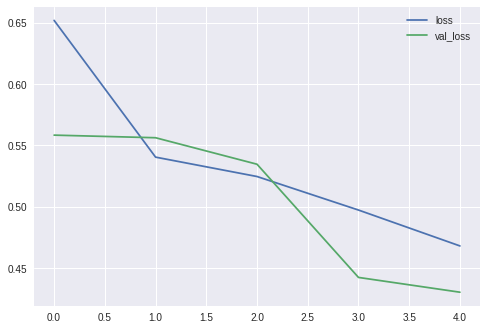

In [3]:
# plot loss function
plt.plot(loss, label='loss')
plt.plot(val_loss, label='val_loss')
plt.legend()
plt.show()

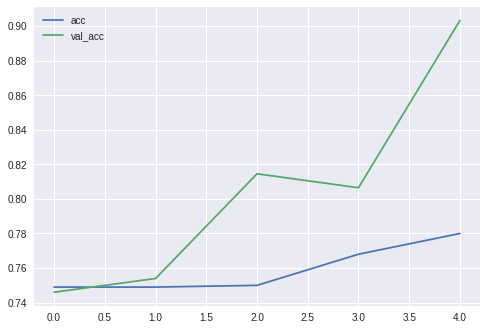

In [4]:
# plot accuracies
plt.plot(accs, label='acc')
plt.plot(val_accs, label='val_acc')
plt.legend()
plt.show()

In [5]:
# display summary of neural net
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 20106)             0         
_________________________________________________________________
embedding_1 (Embedding)      (None, 20106, 100)        2000000   
_________________________________________________________________
conv1d_1 (Conv1D)            (None, 20104, 128)        38528     
_________________________________________________________________
max_pooling1d_1 (MaxPooling1 (None, 6701, 128)         0         
_________________________________________________________________
conv1d_2 (Conv1D)            (None, 6699, 128)         49280     
_________________________________________________________________
max_pooling1d_2 (MaxPooling1 (None, 2233, 128)         0         
_________________________________________________________________
conv1d_3 (Conv1D)            (None, 2231, 128)         49280     
__________

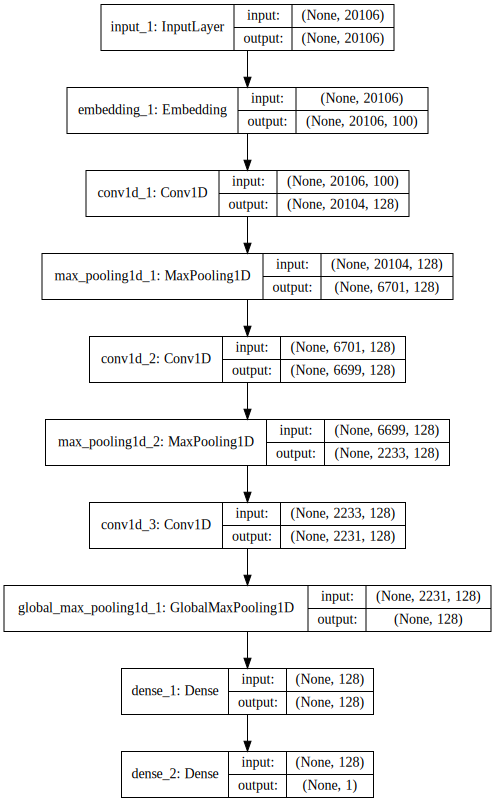

In [6]:
from IPython.display import SVG
from keras.utils.vis_utils import model_to_dot

# display design of neural net
SVG(model_to_dot(model, show_shapes=True).create(prog='dot', format='svg'))